# Implement DeepVelo in gastrulation erythroid maturation

To compare with [Cui et al.](https://www.biorxiv.org/content/10.1101/2022.04.03.486877v2.full) in bioRxiv (doi: https://doi.org/10.1101/2022.04.03.486877; version 2), in this notebook, we follow the instructions of [DeepVelo](https://www.biorxiv.org/content/10.1101/2022.04.03.486877v2) and implement DeepVelo in gastrulation erythroid maturation data. The selected cells with genes in gastrulation erythroid maturation data are the same as the datasets used in our study. The input data could be downloaded from [GastrulationErythroid.h5ad](https:DentateGyrus.h5ad).

## Build environment and install dependencies

We create the environment of DeepVelo by running the commands below in an anaconda environment. We download and install DeepVelo from https://github.com/bowang-lab/DeepVelo on the main thread on 08/03/2022 (version: 0.2.5rc1). The code could also be downloaded [here](https://github.com/bowang-lab/DeepVelo). We install cellDancer to plot figures. 

`conda create -n deepvelo python=3.7.6`

`conda activate deepvelo`

`pip install 'your_path/DeepVelo'`

`pip install 'your_path/Source Code/cellDancer'`

`pip install -r 'your_path/Source Code/cellDancer/requirements.txt'`

`pip install numpy==1.21.1`

`pip install anndata==0.8.0`

# Import packages

In [1]:
import numpy as np
import scvelo as scv
import torch
from umap import UMAP
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu

from deepvelo.utils import velocity, velocity_confidence, update_dict
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants

# set random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params(
    "scvelo", transparent=False
)

import anndata as ann
from adata_to_df import adata_to_df
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap

%load_ext autoreload
%autoreload 2

# Load gastrulation erythroid maturation data

In [2]:
adata=ann.read_h5ad('your_path/GastrulationErythroid.h5ad')

# Run DeepVelo

We run DeepVelo with the same configurations in the instruction. To be a fair comparison, we activated the prediction of unspliced reads. We set n_gpu to 0 to run DeepVelo in CPU. 

In [3]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo_GastrulationErythroid", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}}, # The ratio of spliced reads is 94.8% (more than 85%). Suggest using coeff_s 1.0.
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
    "arch":{"args":{"pred_unspliced":True}},  # To be a fair comparison, we activated the prediction of unspliced reads.
    "n_gpu":0, # enable to use CPU
}
configs = update_dict(Constants.default_configs, configs)

# initial velocity of DeepVelo
velocity(adata, mask_zero=False)

trainer = train(adata, configs)

adata.write('your_path/GastrulationErythroid_pred_DeepVelo.h5ad')

The ratio of spliced reads is 94.8% (more than 85%). Suggest using coeff_s 1.0.
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([12329, 2000])
velo_mat shape: (12329, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)
--> added 'cell_specific_alpha' (adata.layers)


# Visualize the phase portraits of sample genes

In [4]:
adata=ann.read('your_path/GastrulationErythroid_pred_DeepVelo.h5ad')
adata.var['velocity_genes']=True
scv.tl.velocity_graph(adata, n_jobs=16)

computing velocity graph (using 16/16 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:04:50) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [5]:
%%capture
# project the RNA velocity to vector fields in the embedding space. adata.layers['velocity_umap'] was added.
scv.pl.velocity_embedding(
    adata,
    basis="umap",
    arrow_length=6,
    arrow_size=1.2,
    dpi=150,
)

In [6]:
# transfer anndata to pandas dataframe
DeepVelo_esti_df_gastrulation=adata_to_df(adata,embed_para='X_umap',embed_pred_para='velocity_umap')
DeepVelo_esti_df_gastrulation

,gene_name,unsplice,splice,unsplice_predict,splice_predict,cellID,clusters,embedding1,embedding2,velocity1,velocity2
0,Sox17,0.000000,0.043971,0.027578,0.031995,cell_363,Blood progenitors 2,3.460521,15.574629,0.031584,0.003942
1,Sox17,0.000000,0.000000,0.040726,0.000000,cell_382,Blood progenitors 2,2.490433,14.971734,0.034523,0.011579
2,Sox17,0.000000,0.018161,0.038146,0.012877,cell_385,Blood progenitors 2,2.351203,15.267069,0.022792,0.012662
3,Sox17,0.000000,0.000000,-0.051275,0.000000,cell_393,Blood progenitors 2,5.899098,14.388825,0.020988,-0.013115
4,Sox17,0.000000,0.000000,-0.000146,0.000000,cell_398,Blood progenitors 2,4.823139,15.374831,0.038136,-0.010268
...,...,...,...,...,...,...,...,...,...,...,...
24657995,Gm47283,0.214961,1.145533,0.202261,2.668196,cell_139318,Erythroid3,8.032358,7.603037,-0.007321,0.046530
24657996,Gm47283,0.300111,1.072944,-0.198353,3.451556,cell_139321,Erythroid3,10.352904,6.446736,0.002424,0.037210
24657997,Gm47283,0.292607,1.199875,-0.020040,3.126351,cell_139326,Erythroid3,9.464873,7.261099,-0.005770,0.043104
24657998,Gm47283,0.266031,1.114659,0.100161,3.021812,cell_139327,Erythroid3,9.990495,7.243880,-0.005780,0.049291


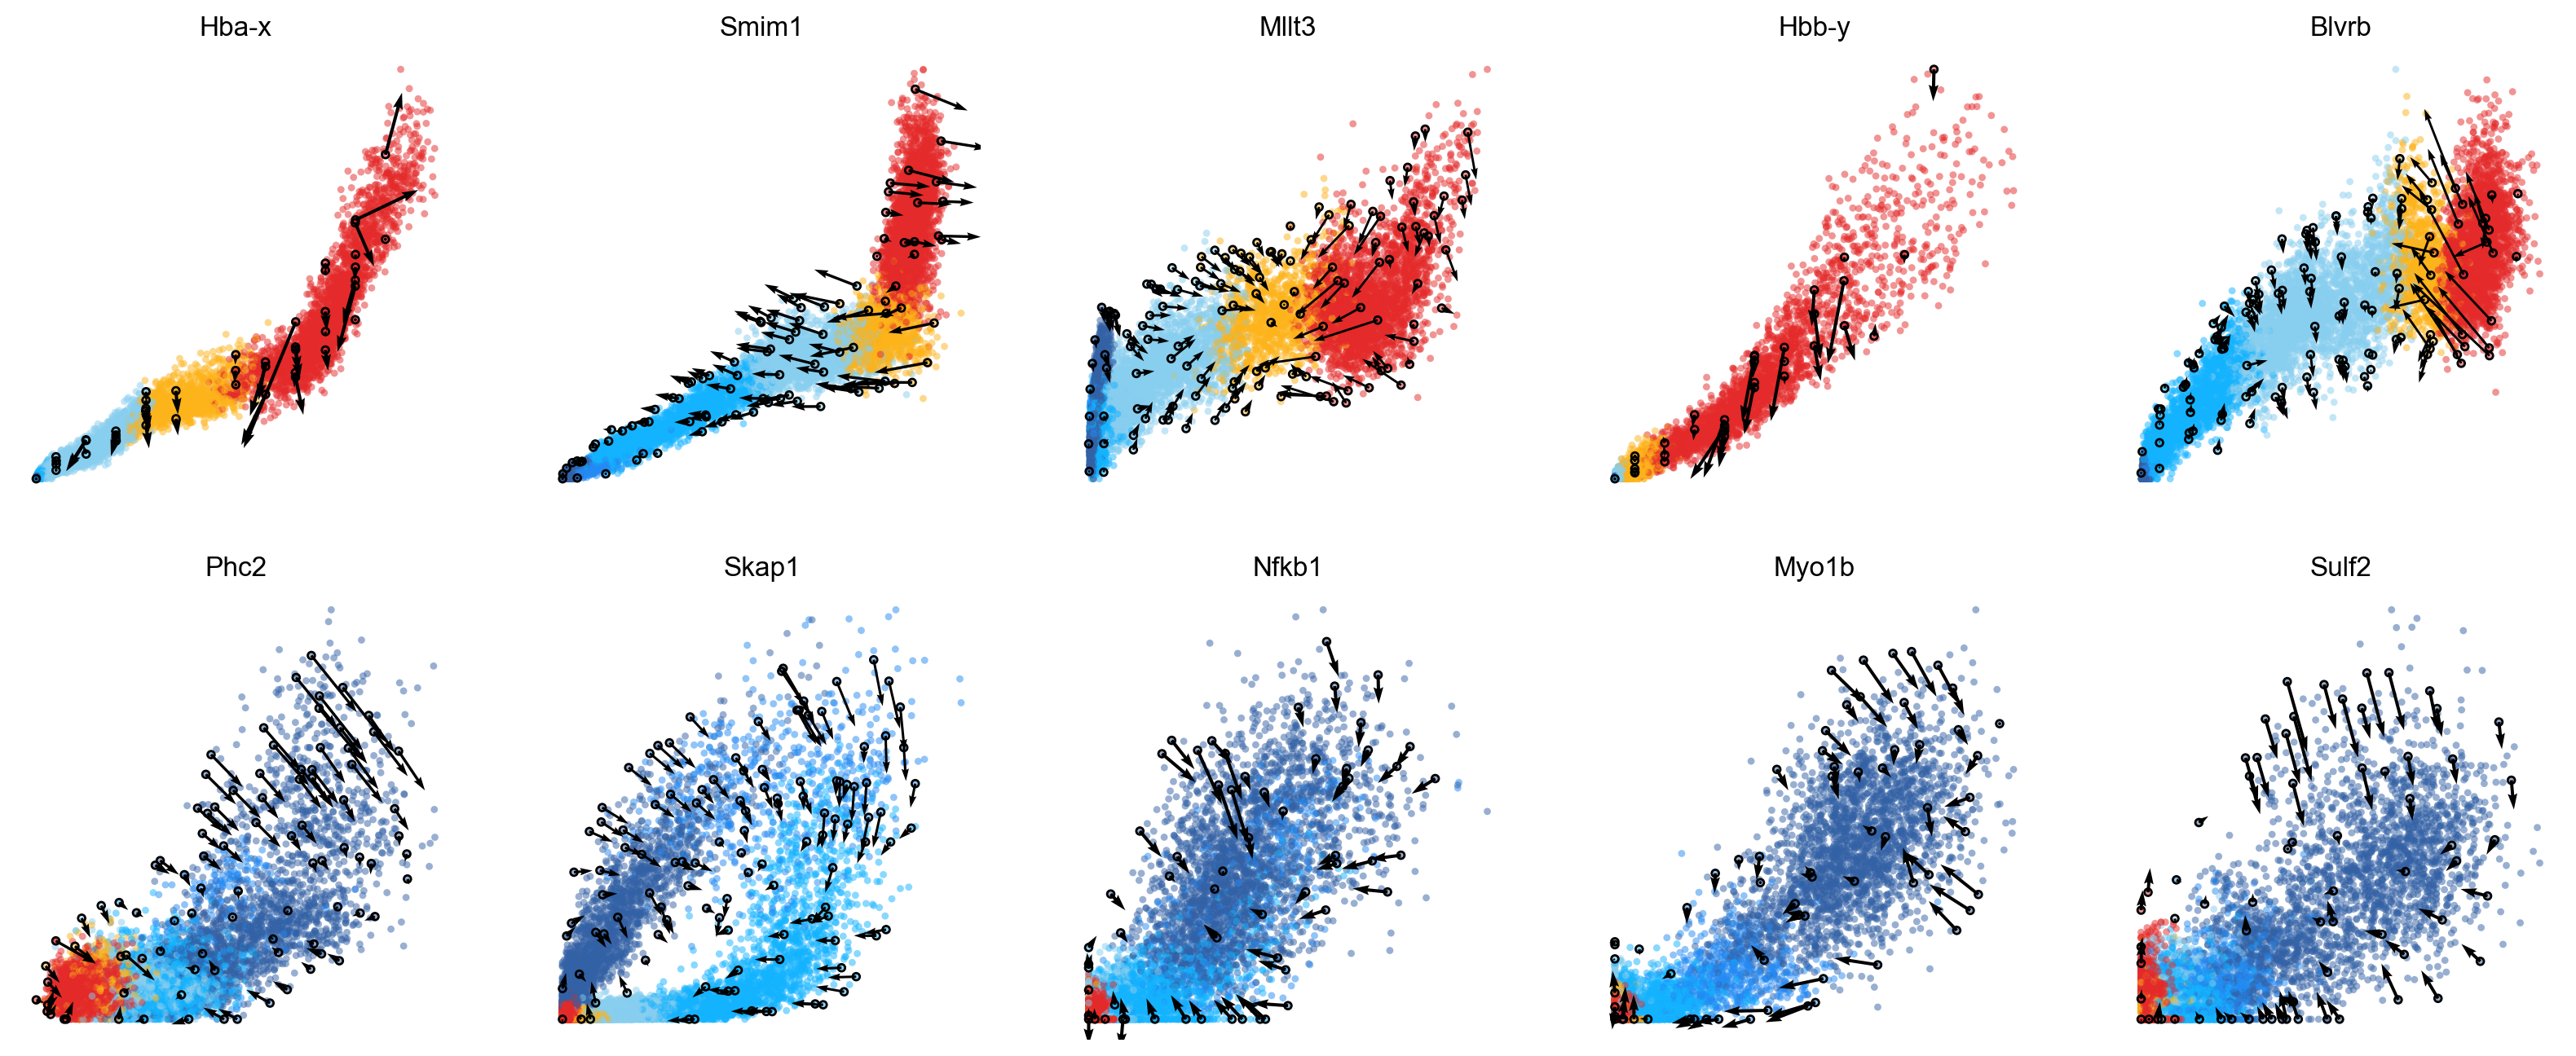

In [7]:
gene_list=['Hba-x','Smim1','Mllt3','Hbb-y','Blvrb','Phc2','Skap1','Nfkb1','Myo1b','Sulf2']

ncols=5
height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=DeepVelo_esti_df_gastrulation,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_erythroid,
        alpha=0.5,
        s = 10,
        velocity=True,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')

plt.show()

# Project the RNA velocity to vector fields in the embedding space for transcriptional boost genes

To have a fair comparison between our method and DeepVelo, we also implement DeepVelo to datasets with MURK genes only and project the RNA velocity in embedding space. The MURK gene list could be obtained from [Additional file 3: Table S2](https://static-content.springer.com/esm/art%3A10.1186%2Fs13059-021-02414-y/MediaObjects/13059_2021_2414_MOESM3_ESM.csv) in the work of [Barile et al](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02414-y). 

In [8]:
adata=ann.read_h5ad('your_path/GastrulationErythroid.h5ad')
# murk genes
murk_genes=pd.read_csv('your_path/13059_2021_2414_MOESM3_ESM.csv')['index']
adata_M_murk=adata[:,adata.var_names.isin(murk_genes)]

## Run DeepVelo

In [9]:
# set random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
    "arch":{"args":{"pred_unspliced":True}}, 
    "n_gpu":0, # enable to use CPU
}
configs = update_dict(Constants.default_configs, configs)

scv.pp.neighbors(adata_M_murk)

# initial velocity
velocity(adata_M_murk, mask_zero=False)

trainer = train(adata_M_murk, configs)

adata_M_murk.write('your_path/GastrulationErythroid_MURK_pred_DeepVelo.h5ad')

adata_M_murk.var['velocity_genes']=True
scv.tl.velocity_graph(adata_M_murk, n_jobs=16)

The ratio of spliced reads is 94.8% (more than 85%). Suggest using coeff_s 1.0.
computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([12329, 61])
velo_mat shape: (12329, 61)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)
--> added 'cell_specific_alpha' (adata.layers)
computing velocity graph (using 16/16 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:00:35) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [10]:
%%capture
# project the RNA velocity to vector fields in the embedding space. adata.layers['velocity_umap'] was added.
scv.pl.velocity_embedding(
    adata_M_murk,
    basis="umap",
    arrow_length=6,
    arrow_size=1.2,
    dpi=300,
)

In [11]:
# transfer anndata to pandas dataframe
DeepVelo_MURK_esti_df_gastrulation_murk=adata_to_df(adata_M_murk,embed_para='X_umap',embed_pred_para='velocity_umap')
DeepVelo_MURK_esti_df_gastrulation_murk

,gene_name,unsplice,splice,unsplice_predict,splice_predict,cellID,clusters,embedding1,embedding2,velocity1,velocity2
0,Mgst3,0.000000,0.119450,-0.055177,0.164721,cell_363,Blood progenitors 2,3.460521,15.574629,0.033070,0.005255
1,Mgst3,0.000000,0.097280,0.062043,0.129332,cell_382,Blood progenitors 2,2.490433,14.971734,0.041864,0.018434
2,Mgst3,0.000000,0.107186,0.060394,0.149407,cell_385,Blood progenitors 2,2.351203,15.267069,0.032273,0.018431
3,Mgst3,0.000000,0.402772,-1.625632,0.068105,cell_393,Blood progenitors 2,5.899098,14.388825,0.004421,-0.017116
4,Mgst3,0.000000,0.202537,-0.328630,0.229713,cell_398,Blood progenitors 2,4.823139,15.374831,0.039207,-0.012490
...,...,...,...,...,...,...,...,...,...,...,...
752064,Alas2,0.054983,5.450834,-4.157641,2.948867,cell_139318,Erythroid3,8.032358,7.603037,0.012696,-0.001004
752065,Alas2,0.036798,6.200462,-2.021477,3.312228,cell_139321,Erythroid3,10.352904,6.446736,-0.014795,0.003976
752066,Alas2,0.031082,5.794872,-2.583268,1.705392,cell_139326,Erythroid3,9.464873,7.261099,-0.042710,-0.013285
752067,Alas2,0.026151,5.638885,-2.686314,2.487473,cell_139327,Erythroid3,9.990495,7.243880,-0.002904,-0.004862


## Plot velocity in embedding space

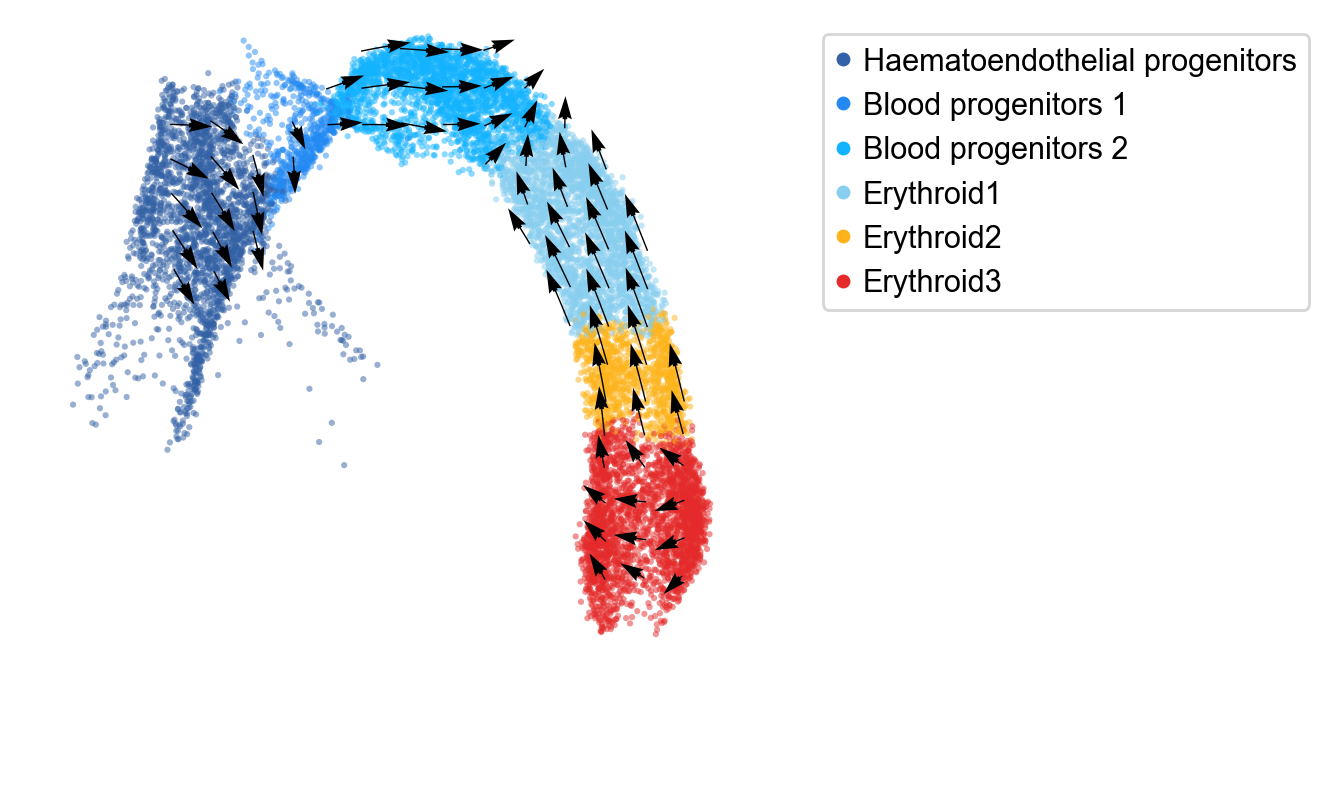

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
cdplt.scatter_cell(ax,
                   DeepVelo_MURK_esti_df_gastrulation_murk,
                   colors=colormap.colormap_erythroid,
                   alpha=0.5,
                   s=5,
                   velocity=True,
                   legend='on',
                   min_mass=200,
                   arrow_grid=(20,40),
                   custom_xlim=[-6,13],
                   custom_ylim=[2,16])
ax.axis('off')
plt.show()